In [2]:
import statsmodels.formula.api as smf
import statsmodels.tsa.arima.api as tsf
import statsmodels.stats.outliers_influence as oi
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt

import re
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape

from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
from typing import List, Dict

## Utility Functions

In [3]:
def get_lags(df, target_col, nlags=1):
    lags = df.copy()
    for i in range(1, nlags+1):
        lag = lags.shift(i)
        cols = lags.columns.values.tolist()
        lags = pd.concat([lags, lag[target_col]], 1)
        cols.append(str.format('lag_{0}', i))
        lags.columns = cols 
    return lags


def seasonal_decomp(data, col_name):
    season = seasonal_decompose(x=data[col_name])
    season_fig = season.plot()
    season_fig.set_figheight(10)
    season_fig.set_figwidth(20)
    
def print_mape(y_pred, y_true):
    m = mape(y_pred=y_pred, y_true=y_true)
    print(str.format("MAPE: {0:0.00f}%", m*100.00))
    return m

In [4]:
data = pd.read_csv('./data/hurricane/AtlanticTropicalStormData.csv')
data.drop(['Hurricanes', 'MajorHurricanes', 'TotalHurricanes'], 1, inplace=True)
data.index = pd.to_datetime( list(map(lambda yr: str(yr)+'-12-31', data.Year)) )
data.drop('Year', axis=1, inplace=True)
data = data.query("index > '1899-12-31'")
VAL_SIZE = 5
Y_COL = 'TropicalStorms'
X1_COL = 'AvgSeaSurfaceCelsius'
data.tail(25)

,TropicalStorms,AvgSeaSurfaceCelsius
1997-12-31,8.0,0.319667
1998-12-31,14.0,0.417500
1999-12-31,12.0,0.198417
2000-12-31,15.0,0.215917
2001-12-31,15.0,0.331667
2002-12-31,12.0,0.370250
2003-12-31,16.0,0.394333
2004-12-31,15.0,0.355750
2005-12-31,28.0,0.392583
2006-12-31,10.0,0.367917


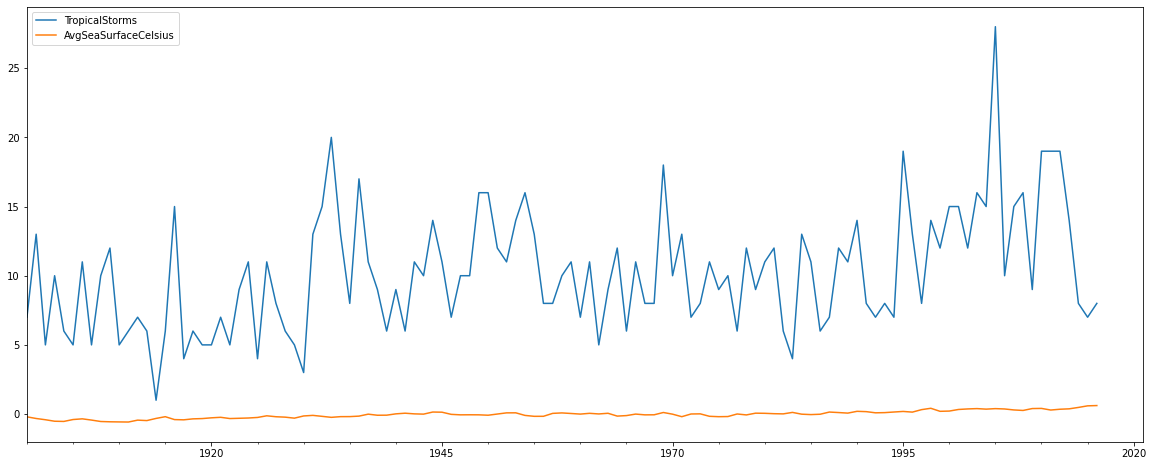

In [5]:
all_plot = data.plot(figsize=(20,8))

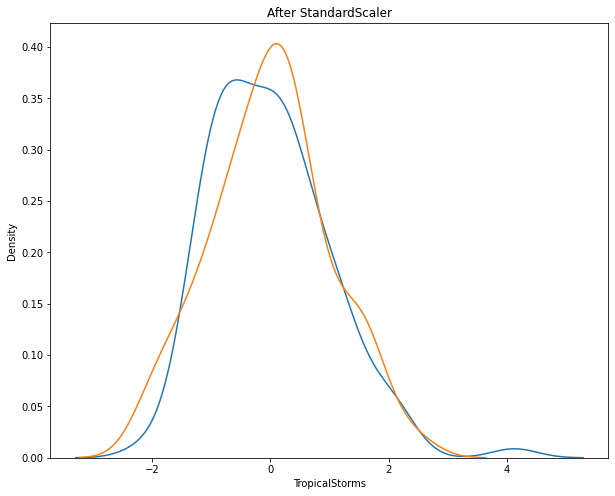

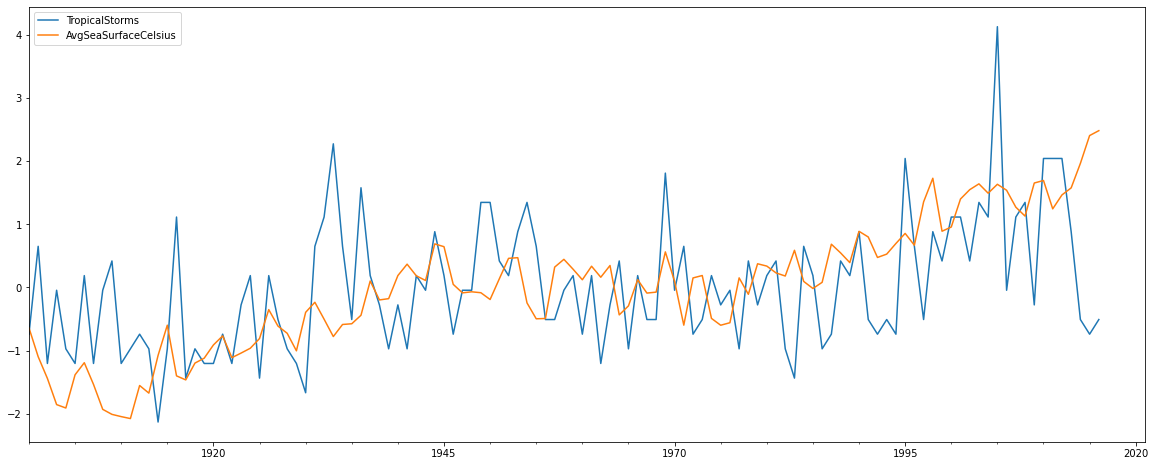

In [6]:
y_scaler = StandardScaler().fit(data[[Y_COL]])
s_scaler = StandardScaler()
normalized = s_scaler.fit_transform(data[[Y_COL, X1_COL]])
normalized = pd.DataFrame(normalized, columns=[Y_COL, X1_COL])
normalized.index = data.index

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After StandardScaler')

sns.kdeplot(normalized[Y_COL], ax=ax1)
sns.kdeplot(normalized[X1_COL], ax=ax1)
series = normalized[[Y_COL, X1_COL]].plot(figsize=(20,8))

In [7]:
train = data.drop(data.tail(VAL_SIZE).index, inplace=False)
val = data.drop(train.index, inplace=False)

In [8]:
reg_model = smf.ols("TropicalStorms ~ AvgSeaSurfaceCelsius", train).fit()
reg_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:                OLS              Adj. R-squared:     0.158   
Dependent Variable:   TropicalStorms   AIC:                656.9299
Date:                 2021-06-11 13:42 BIC:                662.4543
No. Observations:     117              Log-Likelihood:     -326.46 
Df Model:             1                F-statistic:        22.72   
Df Residuals:         115              Prob (F-statistic): 5.53e-06
R-squared:            0.165            Scale:              15.799  
-------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|  [0.025  0.975]
-------------------------------------------------------------------
Intercept            10.4180   0.3706 28.1092 0.0000 9.6839 11.1522
AvgSeaSurfaceCelsius  6.7071   1.4071  4.7665 0.0000 3.9198  9.4944
-------------------------------------------------------------------
Omnibus:              12.443        Durbin-Watson:           1.649 
Prob(Omnibus):        0.002         Jarque-Bera (JB):        13.463
Skew:                 0.699         Prob(JB):                0.001 
Kurtosis:             3.899         Condition No.:           4     
===================================================================

"""

<AxesSubplot:ylabel='TropicalStorms'>

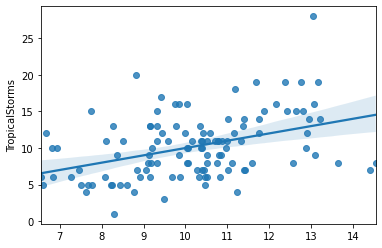

In [9]:
sns.regplot(x=reg_model.fittedvalues, y=train[Y_COL])

<AxesSubplot:>

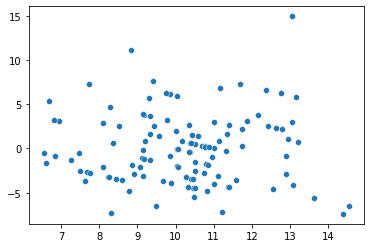

In [10]:
sns.scatterplot(x=reg_model.fittedvalues, y=reg_model.resid)

In [11]:
x1_df = pd.DataFrame(columns=['Residual'], data=reg_model.resid)
x1_df.index = train.index

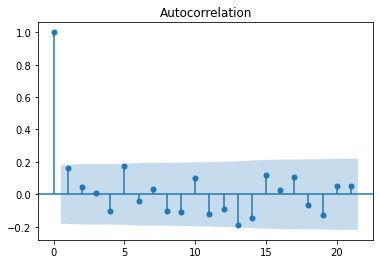

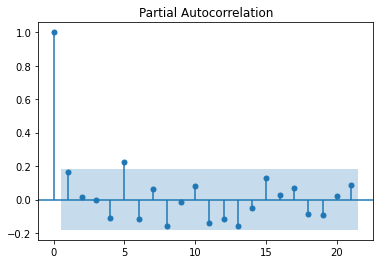

In [12]:
MA = plot_acf(x=x1_df['Residual'])
AR = plot_pacf(x=x1_df['Residual'])

In [13]:
# Fit the initial model.
x1_mod = SARIMAX(endog=x1_df.Residual
              , freq=x1_df.index.inferred_freq
              , order=([10],1,0)
              , enforce_stationarity=True
              , enforce_invertibility=True)

x1_res = x1_mod.fit(disp=False)
x1_res.summary()

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                Residual   No. Observations:                  117
Model:             SARIMAX([10], 1, 0)   Log Likelihood                -349.114
Date:                 Fri, 11 Jun 2021   AIC                            702.227
Time:                         13:42:43   BIC                            707.735
Sample:                     12-31-1900   HQIC                           704.463
                          - 12-31-2016                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L10         0.2744      0.092      2.975      0.003       0.094       0.455
sigma2        23.9166      3.326      7.192      0.000      17.399      30.435
===================================================================================
Ljung-Box (L1) (Q):                  21.03   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.00   Prob(JB):                         0.95
Heteroskedasticity (H):               1.36   Skew:                            -0.07
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
x1_fitted = list(x1_res.fittedvalues[1:]) + [x1_df.Residual[-1]]
print_mape(y_pred=x1_fitted, y_true=x1_df.Residual)

MAPE: 166%


1.658969133543083

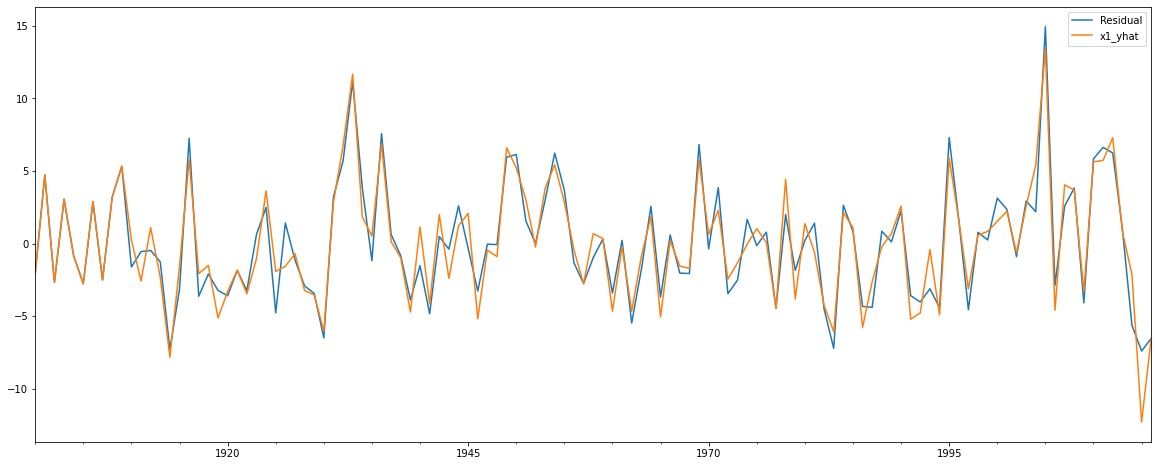

In [15]:
x1_df['x1_yhat'] = x1_fitted
compare = x1_df[['Residual', 'x1_yhat']].plot(figsize=(20,8)).plot()

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


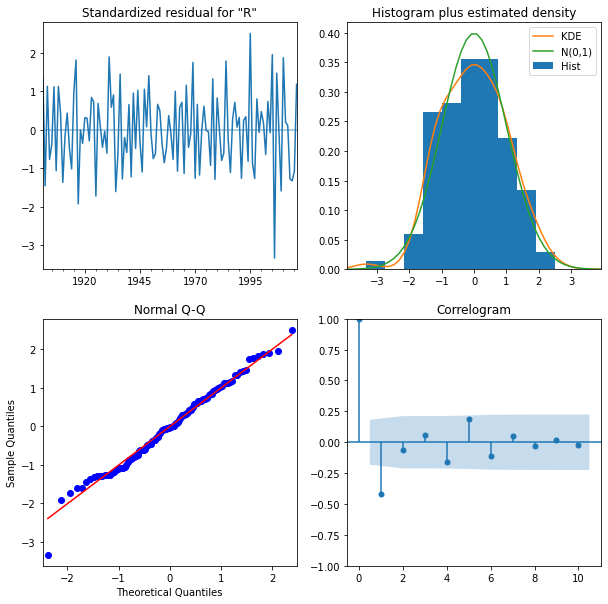

In [16]:
diag = x1_res.plot_diagnostics()
diag.set_figheight(10)
diag.set_figwidth(10)

In [17]:
## Fit Huricanes
# Fit the initial model.
y_mod = SARIMAX(endog=train[Y_COL]
                    , freq=train.index.inferred_freq
                    , order=([2],1,[2,4])
                    , enforce_stationarity=True
                    , enforce_invertibility=True
                    , exog=x1_df.Residual)

y_mod.exog_names=['X1_Residual']
y_res = y_mod.fit(disp=False)
y_res.summary()

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:              TropicalStorms   No. Observations:                  117
Model:             SARIMAX([2], 1, [2, 4])   Log Likelihood                 -95.725
Date:                     Fri, 11 Jun 2021   AIC                            201.450
Time:                             13:42:45   BIC                            215.218
Sample:                         12-31-1900   HQIC                           207.039
                              - 12-31-2016                                         
Covariance Type:                       opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
X1_Residual     0.9795      0.010     99.069      0.000       0.960       0.999
ar.L2           0.9092      0.090     10.117      0.000       0.733       1.085
ma.L2          -1.3701      0.131    -10.444      0.000      -1.627      -1.113
ma.L4           0.4846      0.098      4.964      0.000       0.293       0.676
sigma2          0.3026      0.046      6.537      0.000       0.212       0.393
===================================================================================
Ljung-Box (L1) (Q):                   2.70   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.10   Prob(JB):                         0.56
Heteroskedasticity (H):               1.02   Skew:                             0.11
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


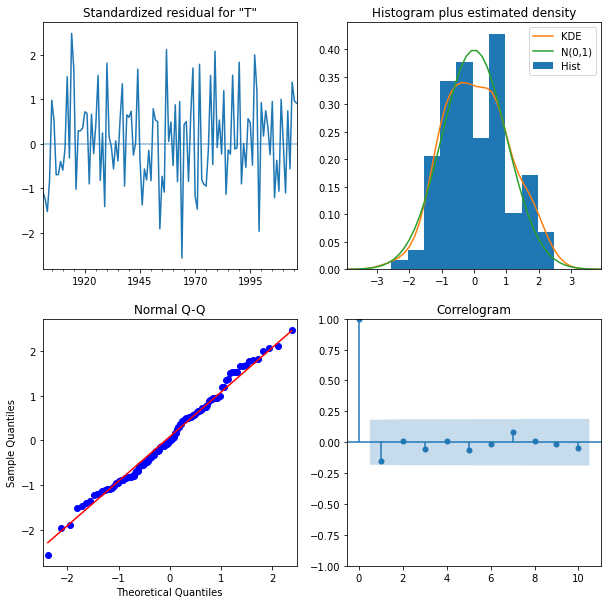

In [18]:
y_diag = y_res.plot_diagnostics()
y_diag.set_figheight(10)
y_diag.set_figwidth(10)

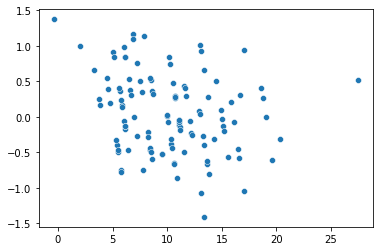

In [19]:
scatter = sns.scatterplot(x=y_res.fittedvalues[1:], y=y_res.resid)

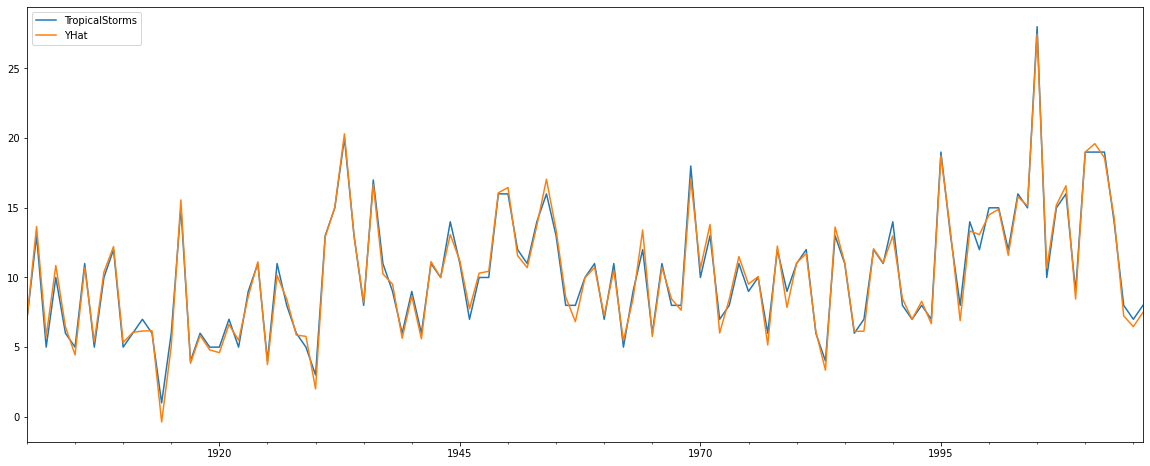

In [20]:
y_predictions = [train.TropicalStorms.to_list()[0]] + list(y_res.fittedvalues[1:])
train['YHat'] = y_predictions
final_plot = train[[Y_COL, 'YHat']].plot(figsize=(20,8)).plot()

In [21]:
print_mape(y_pred=y_predictions, y_true=train.TropicalStorms)

MAPE: 6%


0.06373866525486799

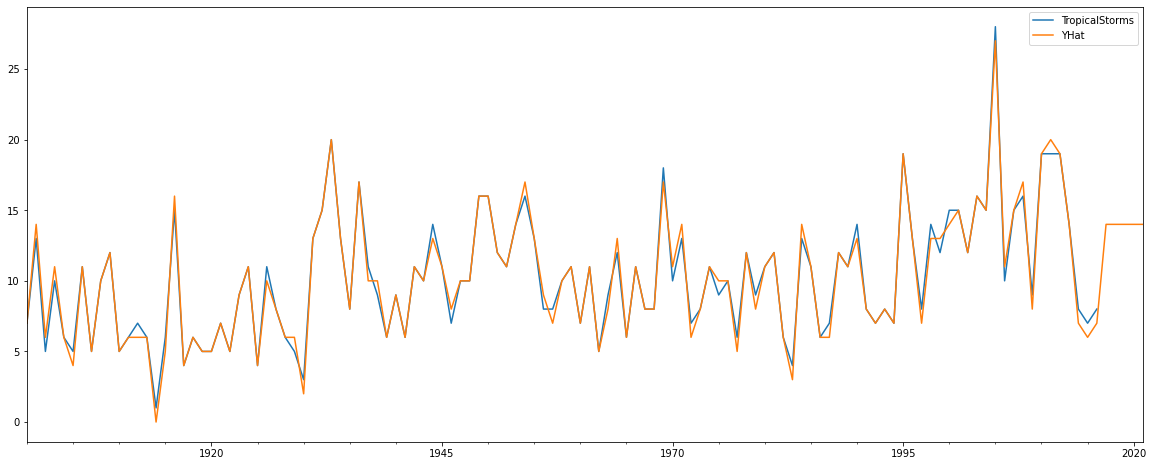

In [22]:
exog_tail = np.zeros(VAL_SIZE)
exog_forecast = list(y_res.forecast(VAL_SIZE, exog=exog_tail))
data['YHat'] = np.round( [train.TropicalStorms.to_list()[0]] + list(y_res.fittedvalues[1:]) + exog_forecast, 0)
final_plot = data[[Y_COL, 'YHat']].plot(figsize=(20,8)).plot()

In [23]:
data['Error'] = np.abs(data.TropicalStorms - data.YHat)
data['PercentError'] = np.divide(data.Error, data.TropicalStorms)
data.tail(10)

,TropicalStorms,AvgSeaSurfaceCelsius,YHat,Error,PercentError
2012-12-31,19.0,0.348500,19.0,0.0,0.000000
2013-12-31,14.0,0.377667,14.0,0.0,0.000000
2014-12-31,8.0,0.479000,7.0,1.0,0.125000
2015-12-31,7.0,0.594083,6.0,1.0,0.142857
2016-12-31,8.0,0.614333,7.0,1.0,0.125000
2017-12-31,NaN,NaN,14.0,NaN,NaN
2018-12-31,NaN,NaN,14.0,NaN,NaN
2019-12-31,NaN,NaN,14.0,NaN,NaN
2020-12-31,NaN,NaN,14.0,NaN,NaN
2021-12-31,NaN,NaN,14.0,NaN,NaN
